In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import optuna 
import logging
from datetime import timedelta, datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from concurrent.futures import ThreadPoolExecutor

# Configuración de logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled = True
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
proporcion_entrenamiento = 0.80
horizon = 12
fourier_order = 4

Y_df_grouped = Y_df.groupby('unique_id')

In [4]:
# Inicialización de DataFrames para resultados
forecast_result_list = []
modelo_precision_forecast_list = []
timestamp = datetime.now().strftime('%Y-%m-%d')

# Función para realizar la optimización con Optuna
def optimize_prophet(trial, ts_prophet, training_duration, horizon):
    param_grid = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95)
    }

    model = Prophet(**param_grid, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.8)
    model.add_country_holidays(country_name='US')

    model.fit(ts_prophet)
    df_cv_model = cross_validation(model, initial=timedelta(days=training_duration), horizon=timedelta(days=horizon), disable_tqdm=True, parallel='threads')
    df_metrics = performance_metrics(df_cv_model)

    smape_score = (df_metrics.groupby('horizon').mean())['smape'].mean()
    mape_score = (df_metrics.groupby('horizon').mean())['mape'].mean()
    mse_score = (df_metrics.groupby('horizon').mean())['mse'].mean()
    rmse_score = (df_metrics.groupby('horizon').mean())['rmse'].mean()
    mae_score = (df_metrics.groupby('horizon').mean())['mae'].mean()

    trial.set_user_attr("mape_score", mape_score)
    trial.set_user_attr("mse_score", mse_score)
    trial.set_user_attr("rmse_score", rmse_score)
    trial.set_user_attr("mae_score", mae_score)

    return smape_score

In [5]:
# Función para realizar el forecast utilizando las últimas 24 semanas
def forecast_for_Ticker(id, ts, horizon, proporcion_entrenamiento):
    try:
        start_time = time.time()  # Inicia el cronómetro

        # Ajuste de la serie temporal
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        # Splitting Training y Validación
        indice_entrenamiento = int(len(ts) * proporcion_entrenamiento)
        ts_entrenamiento = ts.iloc[:indice_entrenamiento].copy()
        ts_validacion = ts.iloc[indice_entrenamiento:].copy()
        ts_prophet = pd.concat([ts_entrenamiento, ts_validacion]).reset_index(drop=True)

        # Implementación del modelo Prophet
        training_duration_days = (len(ts_entrenamiento) * 7) - (horizon * 7)
        horizon_days = horizon * 7

        # Optimización de parámetros
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_prophet(trial, ts_prophet, training_duration_days, horizon_days), n_trials=25, n_jobs=-1, timeout=180)

        smape_score = study.best_value
        accuracy = round((1 - smape_score) * 100, 2) if smape_score < 1 else 0.00

        mape_score = study.best_trial.user_attrs["mape_score"]
        mse_score = study.best_trial.user_attrs["mse_score"]
        rmse_score = study.best_trial.user_attrs["rmse_score"]
        mae_score = study.best_trial.user_attrs["mae_score"]
        best_params = study.best_trial.params

        model = Prophet(**best_params, interval_width=0.8)
        model.add_country_holidays(country_name='US')

        model.fit(ts_prophet)

        # Calcular la última fecha y el inicio del horizonte deseado (las últimas 24 semanas)
        last_date = ts['ds'].max()  # Última fecha de la serie
        start_date = last_date - pd.DateOffset(weeks=horizon)

        # Generar fechas para exactamente las últimas 24 semanas
        future_dates = pd.date_range(start=start_date, end=last_date, freq='W')
        future = pd.DataFrame({'ds': future_dates})

        # Hacer la predicción para estas fechas
        forecast = model.predict(future)

        end_time = time.time()
        forecast_duration = end_time - start_time

        resultado_accuracy = {
            'ticker': id,
            'accuracy': accuracy,
            'smape': smape_score,
            'mape': mape_score,
            'mae': mae_score,
            'mse': mse_score,
            'rmse': rmse_score,
            'forecast_duration_seconds': forecast_duration
        }

        forecast['ticker'] = id
        forecast['yhat'] = forecast['yhat'].round(2)
        forecast['ds'] = forecast['ds'].dt.strftime('%d-%m-%Y')

        return resultado_accuracy, forecast[['ticker', 'ds', 'yhat']].to_dict('records')
    except Exception as e:
        logging.error(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None



# Ejecución en paralelo
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(forecast_for_Ticker, id, ts, horizon, proporcion_entrenamiento) for id, ts in Y_df_grouped]
    for future in futures:
        try:
            result = future.result()
            if result is not None:
                resultado_accuracy, forecast_records = result
                if resultado_accuracy is not None:
                    modelo_precision_forecast_list.append(resultado_accuracy)
                    print(f"SMAPE: {resultado_accuracy.get('smape'):.2f}, MAPE: {resultado_accuracy.get('mape'):.2f}, MAE: {resultado_accuracy.get('mae'):.2f}, MSE: {resultado_accuracy.get('mse'):.2f}, RMSE: {resultado_accuracy.get('rmse'):.2f}, Forecast Duration: {resultado_accuracy.get('forecast_duration_seconds'):.2f} seconds")
                if forecast_records is not None:
                    forecast_result_list.extend(forecast_records)
        except Exception as e:
            print(f'Error processing future: {e}');

SMAPE: 0.14, MAPE: 0.14, MAE: 17.38, MSE: 473.17, RMSE: 21.68, Forecast Duration: 2412.31 seconds
SMAPE: 0.21, MAPE: 0.24, MAE: 29.14, MSE: 1364.84, RMSE: 36.91, Forecast Duration: 2704.66 seconds
SMAPE: 0.31, MAPE: 0.31, MAE: 12160.77, MSE: 245789015.82, RMSE: 15642.09, Forecast Duration: 2032.17 seconds
SMAPE: 0.16, MAPE: 0.16, MAE: 18.74, MSE: 539.29, RMSE: 22.94, Forecast Duration: 2382.10 seconds
SMAPE: 0.09, MAPE: 0.08, MAE: 11.24, MSE: 238.51, RMSE: 15.35, Forecast Duration: 2485.84 seconds
SMAPE: 0.39, MAPE: 0.50, MAE: 111.62, MSE: 16835.33, RMSE: 129.58, Forecast Duration: 2235.36 seconds
SMAPE: 0.13, MAPE: 0.13, MAE: 37.41, MSE: 2460.21, RMSE: 49.32, Forecast Duration: 3669.49 seconds
SMAPE: 0.34, MAPE: 0.32, MAE: 9.77, MSE: 216.50, RMSE: 14.56, Forecast Duration: 2500.13 seconds


In [6]:
modelo_precision_forecast_list = [item for item in modelo_precision_forecast_list if item is not None]
forecast_result_list = [item for item in forecast_result_list if item is not None]

# Crear los dataframes pandas de los resultados
modelo_precision_forecast = pd.DataFrame(modelo_precision_forecast_list)
forecast_result = pd.DataFrame(forecast_result_list)

In [7]:
modelo_precision_forecast

,ticker,accuracy,smape,mape,mae,mse,rmse,forecast_duration_seconds
0,AAPL,85.76,0.142377,0.136827,17.379511,4.731701e+02,21.680154,2412.311364
1,AMZN,79.49,0.205126,0.237633,29.143261,1.364839e+03,36.905730,2704.663309
2,BTC-USD,69.14,0.308571,0.314788,12160.766704,2.457890e+08,15642.085257,2032.171399
3,GOOGL,84.19,0.158050,0.155526,18.735736,5.392920e+02,22.941605,2382.098500
4,IBM,91.32,0.086831,0.083294,11.243614,2.385146e+02,15.346410,2485.840662
5,META,60.72,0.392782,0.497737,111.620664,1.683533e+04,129.576565,2235.357327
6,MSFT,86.91,0.130892,0.130724,37.413152,2.460212e+03,49.317800,3669.485286
7,NVDA,65.75,0.342491,0.321480,9.768887,2.164974e+02,14.564516,2500.131380


In [8]:
forecast_result.tail(20)

,ticker,ds,yhat
76,MSFT,25-08-2024,443.77
77,MSFT,01-09-2024,443.15
78,MSFT,08-09-2024,442.53
79,MSFT,15-09-2024,441.02
80,MSFT,22-09-2024,438.37
81,MSFT,29-09-2024,436.68
82,MSFT,06-10-2024,439.69
83,MSFT,13-10-2024,449.62
84,NVDA,28-07-2024,109.04
85,NVDA,04-08-2024,110.39


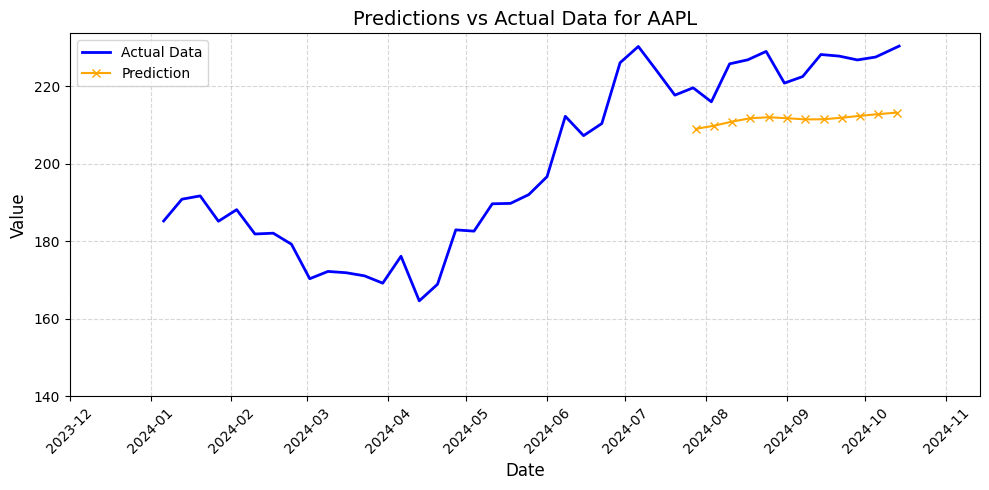

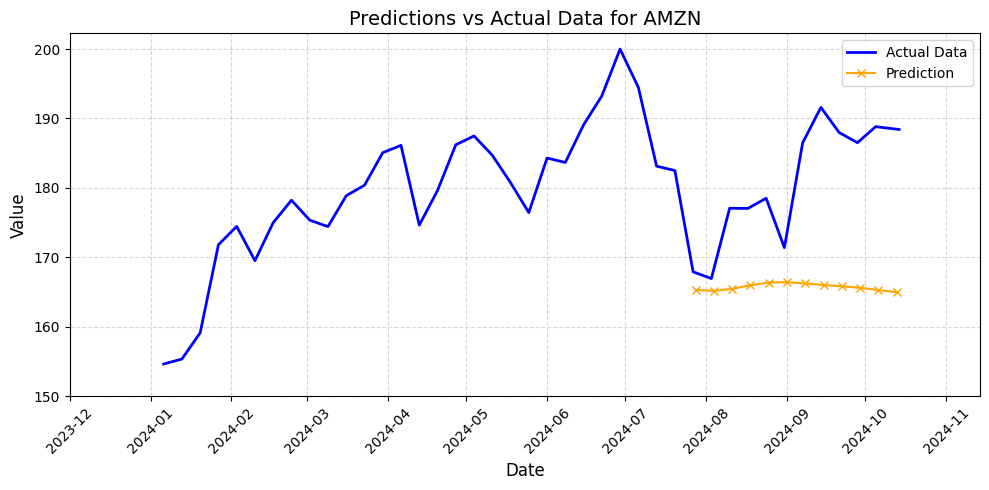

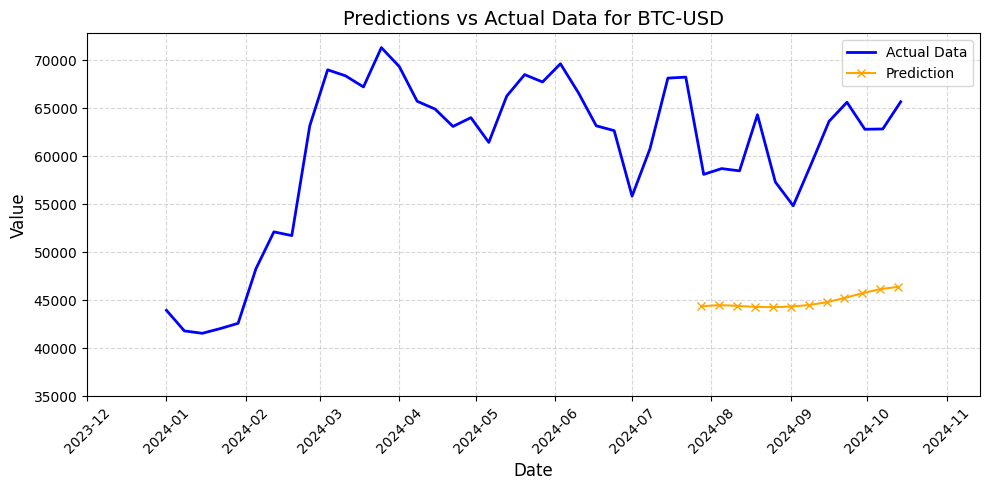

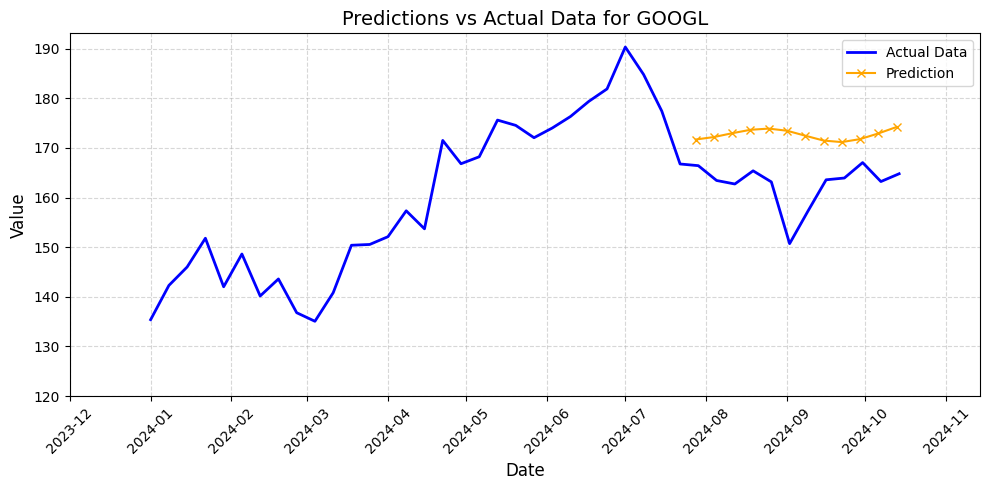

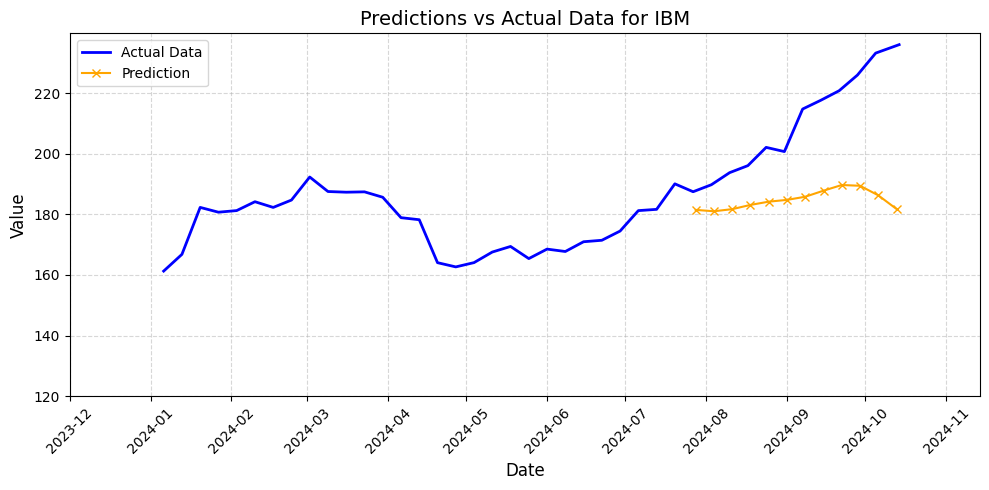

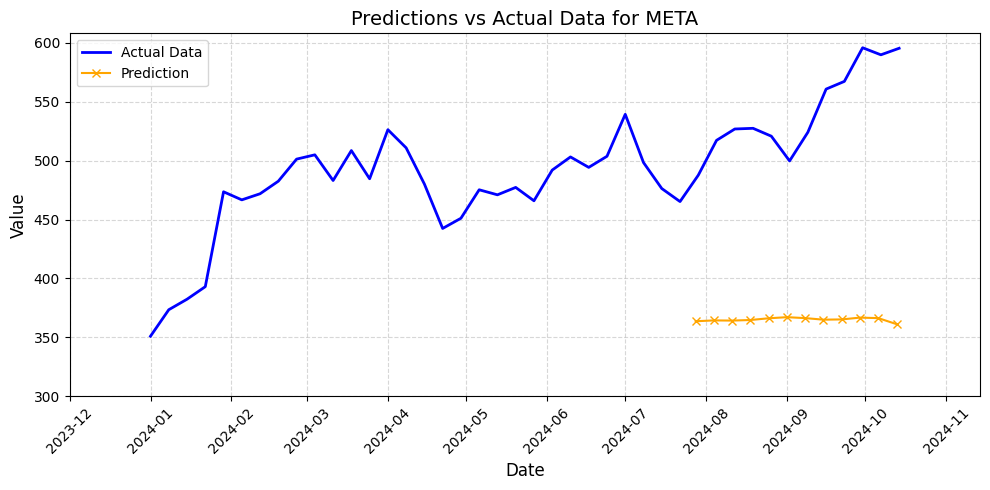

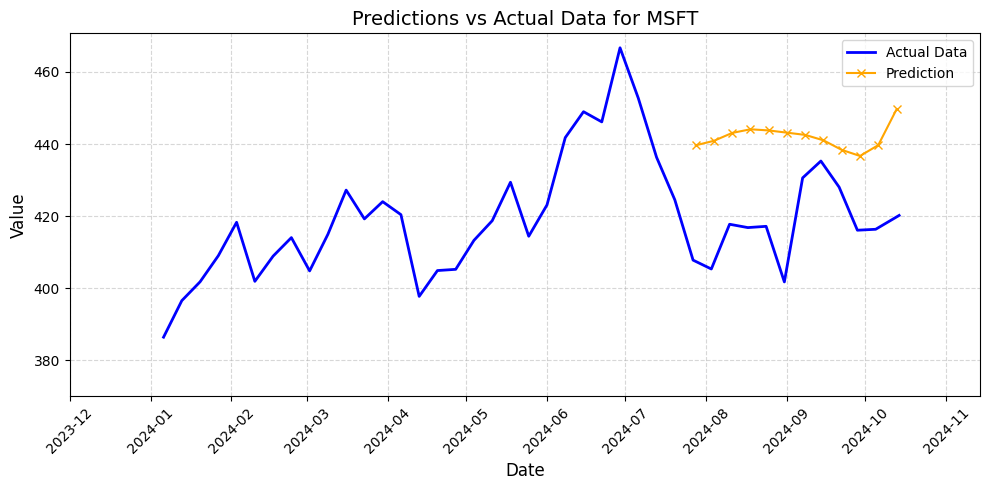

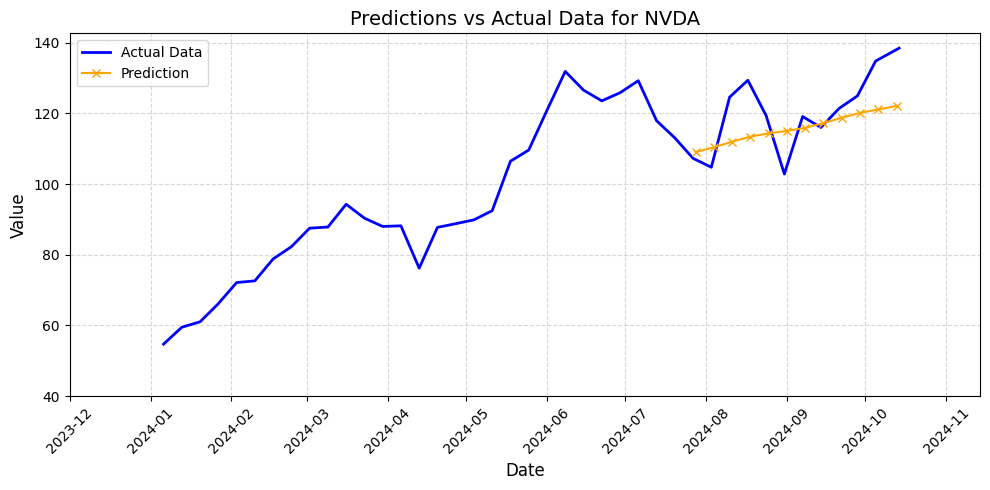

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(forecast_result, Y_df):
    # Ensure 'ds' in forecast_result is in the correct format
    forecast_result['ds'] = pd.to_datetime(forecast_result['ds'], format='%d-%m-%Y')
    Y_df['ds'] = pd.to_datetime(Y_df['ds'], format='%d-%m-%Y')  # Ensure Y_df also has the correct format

    # Filter data from 2024 onwards
    start_date = pd.Timestamp('2024-01-01')
    forecast_result = forecast_result[forecast_result['ds'] >= start_date]
    Y_df = Y_df[Y_df['ds'] >= start_date]

    # Plot predictions and actual data for each ticker
    for ticker in forecast_result['ticker'].unique():
        plt.figure(figsize=(10, 5))

        # Filter predictions and actual data by ticker
        forecast_data = forecast_result[forecast_result['ticker'] == ticker]
        actual_data = Y_df[Y_df['unique_id'] == ticker]

        # Plot actual data as a solid line
        plt.plot(actual_data['ds'], actual_data['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

        # Plot predictions as a dashed line
        plt.plot(forecast_data['ds'], forecast_data['yhat'], label='Prediction', marker='x', color='orange')

        # Configure the plot
        plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.legend(fontsize=10)
        plt.xticks(rotation=45)

        # Adjust axis limits to show all data
        plt.xlim([Y_df['ds'].min() - pd.DateOffset(months=1), Y_df['ds'].max() + pd.DateOffset(months=1)])
        
        # Set the y-axis limit based on the ticker
        if ticker.lower() == 'nvda':
            plt.ylim(bottom=40)  # NVDA starts from 40
        elif ticker.lower() == 'btc-usd':
            plt.ylim(bottom=35000)  # BTC-USD starts from 35,000
        elif ticker.lower() == 'msft':
            plt.ylim(bottom=370)  # MSFT starts from 340
        elif ticker.lower() == 'amzn':
            plt.ylim(bottom=150)  # AMZN starts from 140
        elif ticker.lower() == 'meta':
            plt.ylim(bottom=300)  # META starts from 300
        elif ticker.lower() == 'aapl':
            plt.ylim(bottom=140)  # META starts from 300
        else:
            plt.ylim(bottom=120)  # All other tickers start from 120

        # Adjust figure spacing
        plt.subplots_adjust(bottom=0.15)  # Keep this adjustment if necessary

        plt.tight_layout()
        plt.grid(visible=True, linestyle='--', alpha=0.5)

        # Show the plot
        plt.show()

# Call the function to plot
plot_predictions(forecast_result, Y_df)